## Import and configuration

In [60]:
import urllib3
import requests
import bs4
from selenium import webdriver
from requests_html import AsyncHTMLSession, HTMLSession
from pathlib import Path
import yfinance as yf
%run functions/eurostat.py

mpl.rcParams["figure.figsize"] = 10,10
mpl.style.use("ggplot")

## Scraping eurostat

In [17]:
http = urllib3.PoolManager()
request = http.request("GET", "https://ec.europa.eu/eurostat/web/main/data/database")
page = bs4.BeautifulSoup(request.data.decode("utf8"), "html.parser")
page.find_all(src = "/eurostat/o/NavTree-portlet-prod/images/connector-open.gif")
# explore selenium and other solutions to use so js can render

[]

In [19]:
browser = webdriver.Firefox()
browser.get("https://ec.europa.eu/eurostat/web/main/data/database")
browser.quit()
# Too possible but need to collapse everything manually with webdriver, takes quite a long time
None

In [20]:
# asession = AsyncHTMLSession()
session = HTMLSession()
r = session.get("https://ec.europa.eu/eurostat/web/main/data/database")
r.html.absolute_links
# r.html.render()
# not working in ipython notebooks, run in regular .py - problems with asyncio
None

In [2]:
### BEST WAY: there is a bulk download page on eurostat, use requests-html to get page
session = HTMLSession()
r = session.get("https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?dir=data&sort=1&sort=2&start=all")
links = list(filter(lambda x: x.endswith(".tsv.gz") and x.__contains__("&downfile"), r.html.absolute_links)) # uses bs4 internally to parse html
names = list(map(process_link, links))
# link_mapping = pd.DataFrame(data = {"short_name": names, "urls": links})
link_mapping = pd.DataFrame(index = names, columns = ["links"], data = links)
len(link_mapping)

6505

### Loading datasets

In [3]:
kbc = yf.Ticker("KBC.BR")
kbc_close = kbc.history(period = "max").Close

In [4]:
# link_mapping[link_mapping.index.str.contains("euryld")] # get euryld datasets
interestrates_euryield_daily = pd.read_csv(link_mapping.at["irt_euryld_d.tsv.gz", "links"], delimiter = "\t")
interestrates_euryield_daily.set_index(interestrates_euryield_daily.columns[0], inplace = True)
interestrates_euryield_daily.columns = pd.to_datetime(list(map(process_datestring, interestrates_euryield_daily.columns)))

In [5]:
sorting_bonds = pd.DataFrame(index = interestrates_euryield_daily.index, columns = ["yld_curv", "maturity", "bonds", "geo\\time"])
sorting_bonds["yld_curv"] = pd.Series(sorting_bonds.index).apply(lambda x: x.split(",")[0]).array
sorting_bonds["maturity"] = pd.Series(sorting_bonds.index).apply(lambda x: x.split(",")[1]).array
sorting_bonds["bonds"] = pd.Series(sorting_bonds.index).apply(lambda x: x.split(",")[2]).array
sorting_bonds["geo\\time"] = pd.Series(sorting_bonds.index).apply(lambda x: x.split(",")[3]).array
total_options = 1
for x in sorting_bonds.columns:
    sorting_bonds[x] = sorting_bonds[x].astype("category")
    options = list(sorting_bonds[x].cat.categories)
    print("{} options for {}:".format(len(options), x))
    print("\t", end = "")
    for i, e in enumerate(options):
        if i == len(options) - 1:
            print(e)
        else:
            print(f"{e} - ", end = "")
    total_options *= len(options)
print("Total options = {}".format(total_options))

3 options for yld_curv:
	INS_FWD - PAR - SPOT_RT
30 options for maturity:
	Y1 - Y10 - Y11 - Y12 - Y13 - Y14 - Y15 - Y16 - Y17 - Y18 - Y19 - Y2 - Y20 - Y21 - Y22 - Y23 - Y24 - Y25 - Y26 - Y27 - Y28 - Y29 - Y3 - Y30 - Y4 - Y5 - Y6 - Y7 - Y8 - Y9
2 options for bonds:
	CGB_EA - CGB_EA_AAA
1 options for geo\time:
	EA
Total options = 180


### Plotting and processing

<AxesSubplot:>

<Figure size 720x720 with 0 Axes>

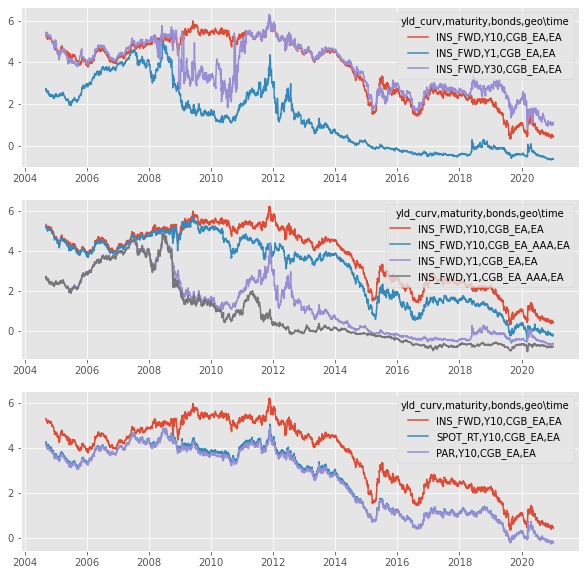

In [6]:
plt.clf()
fig, axs = plt.subplots(3, 1)
selected1 = [
    "INS_FWD,Y10,CGB_EA,EA", # forward regular long term (10 years)
    "INS_FWD,Y1,CGB_EA,EA", # forward regular short term (1 year)
    "INS_FWD,Y30,CGB_EA,EA" # forward regular extra long term (10 years)
]
selected2 = [
    "INS_FWD,Y10,CGB_EA,EA", 
    "INS_FWD,Y10,CGB_EA_AAA,EA", # AAA credit rating? --> safer so less interest
    "INS_FWD,Y1,CGB_EA,EA", 
    "INS_FWD,Y1,CGB_EA_AAA,EA"
]
selected3 = [
    "INS_FWD,Y10,CGB_EA,EA", 
    "SPOT_RT,Y10,CGB_EA,EA", 
    "PAR,Y10,CGB_EA,EA"
]
sns.lineplot(data = interestrates_euryield_daily.T[selected1], ax = axs[0], dashes = None)
sns.lineplot(data = interestrates_euryield_daily.T[selected2], ax = axs[1], dashes = None)
sns.lineplot(data = interestrates_euryield_daily.T[selected3], ax = axs[2], dashes = None)

In [7]:
irt = interestrates_euryield_daily.T[["INS_FWD,Y10,CGB_EA,EA", "INS_FWD,Y1,CGB_EA,EA", "INS_FWD,Y30,CGB_EA,EA"]]
full = irt.merge(kbc_close, left_index = True, right_index = True).rename({"Close": "kbc_close"}, axis = 1)
full.sort_index(inplace = True)
full_perc_start = full.copy()
for k, v in full_perc_start.iteritems():
    full_perc_start[k] = v / v[0] * 100
full_perc_start

,"INS_FWD,Y10,CGB_EA,EA","INS_FWD,Y1,CGB_EA,EA","INS_FWD,Y30,CGB_EA,EA",kbc_close
2004-09-06,100.000000,100.000000,100.000000,100.000000
2004-09-07,99.436090,101.492537,100.000000,99.605148
2004-09-08,99.436090,102.611940,99.816514,100.493561
2004-09-09,98.684211,100.000000,99.266055,100.493561
2004-09-10,98.496241,97.761194,98.715596,100.000000
...,...,...,...,...
2021-01-04,9.210526,-23.880597,20.550459,180.654839
2021-01-05,8.646617,-22.761194,18.715596,174.660064
2021-01-06,8.834586,-22.014925,20.366972,184.151784
2021-01-07,8.646617,-22.388060,20.183486,188.772749


<AxesSubplot:>

<Figure size 720x720 with 0 Axes>

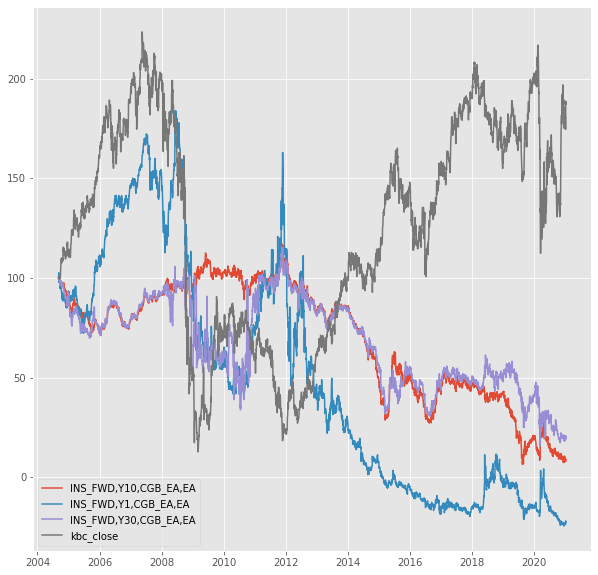

In [8]:
plt.clf()
fig, ax = plt.subplots(1, 1)
sns.lineplot(data = full_perc_start, ax = ax, dashes = None)

In [9]:
full_perc_start.corr(method = "spearman")

,"INS_FWD,Y10,CGB_EA,EA","INS_FWD,Y1,CGB_EA,EA","INS_FWD,Y30,CGB_EA,EA",kbc_close
"INS_FWD,Y10,CGB_EA,EA",1.000000,0.744499,0.762787,-0.581076
"INS_FWD,Y1,CGB_EA,EA",0.744499,1.000000,0.834367,-0.161845
"INS_FWD,Y30,CGB_EA,EA",0.762787,0.834367,1.000000,-0.337437
kbc_close,-0.581076,-0.161845,-0.337437,1.000000


In [18]:
population_projection = pd.read_csv(link_mapping.at["proj_19np.tsv.gz", "links"], delimiter = "\t", low_memory = True)
population_projection.set_index("projection,unit,sex,age,geo\\time", inplace = True)

In [174]:
# explanation: https://ec.europa.eu/eurostat/cache/metadata/en/demo_gind_esms.htm
population = pd.read_csv(link_mapping.at["demo_gind.tsv.gz", "links"], delimiter = "\t")
population = population.set_index("indic_de,geo\\time").applymap(lambda x: re.subn(r"[a-zA-Z]*", "", x)[0]).T
population.index = population.index.map(int)
population.sort_index(inplace = True)
population.columns = pd.MultiIndex.from_tuples(list(map(lambda x: tuple(x.split(",")), population.columns.to_list())))
population = population.replace(": ", pd.NA).convert_dtypes()

In [176]:
population.columns.levels[0]

Index(['AVG', 'CNMIGRAT', 'CNMIGRATRT', 'DEATH', 'FAVG', 'FDEATH', 'FJAN',
       'FLBIRTH', 'GBIRTHRT', 'GDEATHRT', 'GROW', 'GROWRT', 'JAN', 'LBIRTH',
       'MAVG', 'MDEATH', 'MIGT', 'MIGTRT', 'MJAN', 'MLBIRTH', 'NATGROW',
       'NATGROWRT', 'NATT', 'NATTRT', 'POPSHARE', 'POPSHARE_EU27_2020', 'POPT',
       'POPTRT'],
      dtype='object')

<AxesSubplot:ylabel='BE'>

<Figure size 720x720 with 0 Axes>

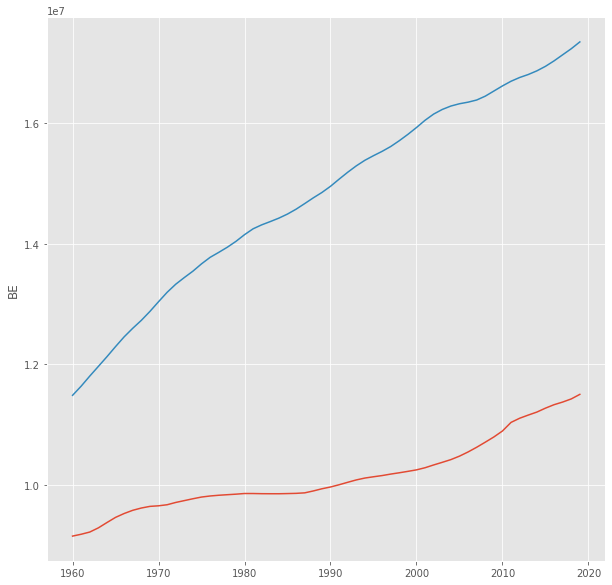

In [175]:
plt.clf()
fig, ax = plt.subplots(1, 1)
sns.lineplot(data = population.AVG.BE.astype("Int64"), ax = ax)
sns.lineplot(data = population.AVG.NL.astype("Int64"), ax = ax)